 # Code 
 


In [1]:
from __future__ import division
import time
import torch
from torch.autograd import Variable
import cv2
from utils.util import *
from Darknet_VOC import Darknet
import random
import argparse
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
%cd

C:\Users\1201m


### Build the YOLO V3 network



In [8]:
####NO NEED OF STORING ON LOCATION ig####
model = Darknet()
model.load_state_dict(torch.load(r"C:\Users\1201m\YOLO-V3-in-Pytorch-A-Tutorial-on-Implementation-of-YOLO-V3-Algorithm\Dartnet_VOC_Weights_trial_fl"))#,map_location=lambda storage, loc: storage
CUDA = torch.cuda.is_available()
if CUDA:
    model.cuda()
model.eval()

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch

### Preprocess the Image 



In [9]:
def prep_image(img, inp_dim):

    h, w, _ = img.shape
    dim_diff = np.abs(h - w)
    # Upper (left) and lower (right) padding
    pad1, pad2 = dim_diff // 2, dim_diff - dim_diff // 2
    # Determine padding
    pad = ((pad1, pad2), (0, 0), (0, 0)) if h <= w else ((0, 0), (pad1, pad2), (0, 0))
    # Add padding
    pad_img = np.pad(img, pad, 'constant', constant_values=128)
    orig_im = pad_img
    img = cv2.resize(orig_im, (inp_dim, inp_dim))
    img_ = img[:, :, ::-1].transpose((2, 0, 1)).copy()
    img_ = torch.from_numpy(img_).float().div(255.0).unsqueeze(0)
    return img_, orig_im

In [22]:
model.image_size = 416
inp_dim = int(model.image_size)

frame = cv2.imread(r"C:\Users\1201m\YOLO-V3-in-Pytorch-A-Tutorial-on-Implementation-of-YOLO-V3-Algorithm\imgs\img2.jpg")
img, orig_im = prep_image(frame, inp_dim)

if CUDA:
    img = img.cuda()
    
img.shape

torch.Size([1, 3, 416, 416])

### Check the final prediction and network output

Feeding image into network will generate 3 different output layers as demonstrated from the below code. "predict_transform" funcation has been embedding into "Darknet_VOC.py". Pascal VOC dataset has 20 classes. Thus the depth of output layer is 3x(5+20) = 75. 

In [11]:
Final_pre, outputlayer_3, outputlayer_2, outputlayer_1 = model(Variable(img), CUDA)
print('Final prediction shape is', Final_pre.shape)
print('layer_3 output shape is {}, layer_2 output shape is {}, layer_1 output shape is {}'
      .format(outputlayer_3.shape, outputlayer_2.shape, outputlayer_1.shape))

Final prediction shape is torch.Size([1, 10647, 25])
layer_3 output shape is torch.Size([1, 75, 52, 52]), layer_2 output shape is torch.Size([1, 75, 26, 26]), layer_1 output shape is torch.Size([1, 75, 13, 13])


### Build predict_transfrom function

let's have a close look on this function by taking the outputlayer_3 as an example. This funcation accepts the network output, input image size, corresponding anchor dimensions, number of classes. The final prediction is transfered step by step as explained before. 

In [12]:
def predict_transform(prediction, inp_dim, anchors, num_classes, CUDA = True):
    
    batch_size = prediction.size(0)
    stride =  inp_dim // prediction.size(2)
    grid_size = inp_dim // stride
    bbox_attrs = 5 + num_classes
    num_anchors = len(anchors)
    
    prediction = prediction.view(batch_size, bbox_attrs*num_anchors, grid_size*grid_size)
    prediction = prediction.transpose(1,2).contiguous()
    prediction = prediction.view(batch_size, grid_size*grid_size*num_anchors, bbox_attrs)
    anchors = [(a[0]/stride, a[1]/stride) for a in anchors]

    #Sigmoid the  centre_X, centre_Y. and object confidencce
    prediction[:,:,0] = torch.sigmoid(prediction[:,:,0])
    prediction[:,:,1] = torch.sigmoid(prediction[:,:,1])
    prediction[:,:,4] = torch.sigmoid(prediction[:,:,4])
    
    #Add the center offsets
    grid = np.arange(grid_size)
    a,b = np.meshgrid(grid, grid)

    x_offset = torch.FloatTensor(a).view(-1,1)
    y_offset = torch.FloatTensor(b).view(-1,1)

    if CUDA:
        x_offset = x_offset.cuda()
        y_offset = y_offset.cuda()

    x_y_offset = torch.cat((x_offset, y_offset), 1).repeat(1,num_anchors).view(-1,2).unsqueeze(0)

    prediction[:,:,:2] += x_y_offset

    #log space transform height and the width
    anchors = torch.FloatTensor(anchors)

    if CUDA:
        anchors = anchors.cuda()

    anchors = anchors.repeat(grid_size*grid_size, 1).unsqueeze(0)
    prediction[:,:,2:4] = torch.exp(prediction[:,:,2:4])*anchors
    
    prediction[:,:,5: 5 + num_classes] = torch.sigmoid((prediction[:,:, 5 : 5 + num_classes]))

    prediction[:,:,:4] *= stride
    
    return prediction

In [13]:
prediction_layer_3 = predict_transform(outputlayer_3, inp_dim = 416, anchors = [(10, 13), (16, 30), (33, 23)], num_classes = 20, CUDA = False)
prediction_layer_3.shape

torch.Size([1, 8112, 25])

In [14]:
def write_results(prediction, confidence, num_classes, nms_conf = 0.4):
    conf_mask = (prediction[:,:,4] > confidence).float().unsqueeze(2)
    prediction = prediction*conf_mask
    
    box_corner = prediction.new(prediction.shape)
    box_corner[:,:,0] = (prediction[:,:,0] - prediction[:,:,2]/2)
    box_corner[:,:,1] = (prediction[:,:,1] - prediction[:,:,3]/2)
    box_corner[:,:,2] = (prediction[:,:,0] + prediction[:,:,2]/2) 
    box_corner[:,:,3] = (prediction[:,:,1] + prediction[:,:,3]/2)
    prediction[:,:,:4] = box_corner[:,:,:4]
    
    batch_size = prediction.size(0)

    write = False

    for ind in range(batch_size):
        image_pred = prediction[ind]          #image Tensor
       #confidence threshholding 
       #NMS
    
        max_conf, max_conf_score = torch.max(image_pred[:,5:5+ num_classes], 1)
        max_conf = max_conf.float().unsqueeze(1)
        max_conf_score = max_conf_score.float().unsqueeze(1)
        seq = (image_pred[:,:5], max_conf, max_conf_score)
        image_pred = torch.cat(seq, 1)
        
        non_zero_ind =  (torch.nonzero(image_pred[:,4]))
        try:
            image_pred_ = image_pred[non_zero_ind.squeeze(),:].view(-1,7)
        except:
            continue
        
        if image_pred_.shape[0] == 0:
            continue           
  
        #Get the various classes detected in the image
        img_classes = unique(image_pred_[:,-1])  # -1 index holds the class index
        
        
        for cls in img_classes:
            #perform NMS
            #get the detections with one particular class
            cls_mask = image_pred_*(image_pred_[:,-1] == cls).float().unsqueeze(1)
            class_mask_ind = torch.nonzero(cls_mask[:,-2]).squeeze()
            image_pred_class = image_pred_[class_mask_ind].view(-1,7)
            
            #sort the detections such that the entry with the maximum objectness
            #confidence is at the top
            conf_sort_index = torch.sort(image_pred_class[:,4], descending = True )[1]
            image_pred_class = image_pred_class[conf_sort_index]
            idx = image_pred_class.size(0)   #Number of detections
            
            for i in range(idx):
                #Get the IOUs of all boxes that come after the one we are looking at 
                #in the loop
                try:
                    ious = bbox_iou(image_pred_class[i].unsqueeze(0), image_pred_class[i+1:])
                except ValueError:
                    break
            
                except IndexError:
                    break
            
                #Zero out all the detections that have IoU > treshhold
                iou_mask = (ious < nms_conf).float().unsqueeze(1)
                image_pred_class[i+1:] *= iou_mask       
            
                #Remove the non-zero entries
                non_zero_ind = torch.nonzero(image_pred_class[:,4]).squeeze()
                image_pred_class = image_pred_class[non_zero_ind].view(-1,7)
                
            batch_ind = image_pred_class.new(image_pred_class.size(0), 1).fill_(ind)      #Repeat the batch_id for as many detections of the class cls in the image
            seq = batch_ind, image_pred_class
            
            if not write:
                output = torch.cat(seq,1)
                write = True
            else:
                out = torch.cat(seq,1)
                output = torch.cat((output,out))

    try:
        return output
    except:
        return 0

In [15]:
output = Final_pre
confidence = 0.5
nms_thesh = 0.4
num_classes = 20
output = write_results(output, confidence, num_classes, nms_conf=nms_thesh)
output.shape

torch.Size([1, 8])

In [16]:
def load_classes(namesfile):
    fp = open(namesfile, "r")
    names = fp.read().split("\n")[:-1]
    return names

classes = load_classes(r"C:\Users\1201m\YOLO-V3-in-Pytorch-A-Tutorial-on-Implementation-of-YOLO-V3-Algorithm\data\voc.names")
colors = pkl.load(open(r"C:\Users\1201m\YOLO-V3-in-Pytorch-A-Tutorial-on-Implementation-of-YOLO-V3-Algorithm\data\pallete", "rb"))

In [17]:
if isinstance(output, int) == False:
    output[:, 1:5] = torch.clamp(output[:, 1:5], 0.0, float(inp_dim)) / inp_dim
    output[:, [1, 3]] *= orig_im.shape[1]
    output[:, [2, 4]] *= orig_im.shape[0]

### Write Funcation to draw boxes on image

In [18]:
def write(x, img):

    cls = int(x[-1])
    label = "{0}".format(classes[cls])
    c1 = tuple(x[1:3].int())
    c2 = tuple(x[3:5].int())
    color = random.choice(colors)
    print(img.shape)
    #c1 = c1.tolist()
    c=[]
    for i in c1:
        c1_1=i
        c1_1=c1_1.tolist()
        c.append(c1_1)
        print(c)
    c_=[]
    for i in c2:
        c1_1=i
        c1_1=c1_1.tolist()
        c_.append(c1_1)
        print(c_)
    cv2.rectangle(img, c, c_, color, 2)
    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1, 1)[0]
    c_ = c[0] + t_size[0] + 3, c[1] + t_size[1] + 4
    cv2.rectangle(img, c, c_, color, -1)
    cv2.putText(img, label, (c[0], c[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225, 255, 255], 1)

    return img

(500, 500, 3)
[229]
[229, 194]
[274]
[274, 291]


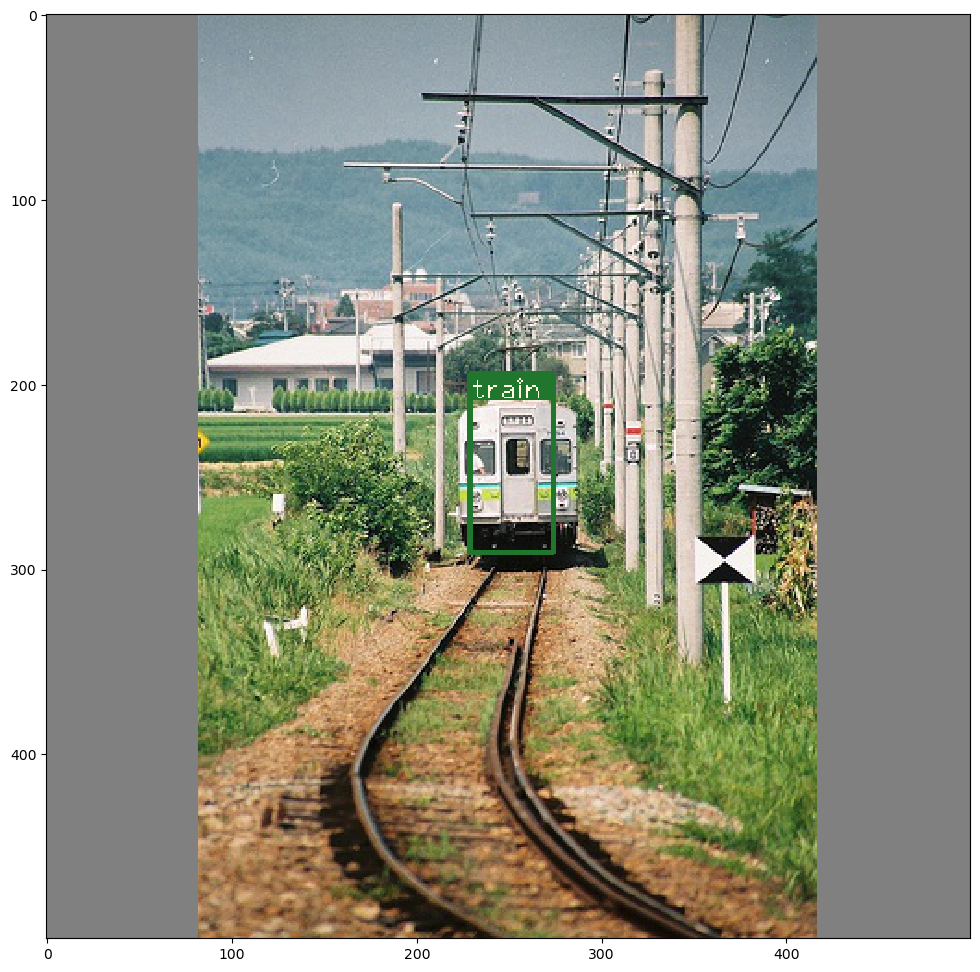

In [23]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

list(map(lambda x: write(x, orig_im), output))
orig_im = orig_im[:,:,::-1]
plt.imshow(orig_im, )